## 9. Estimates true thickness of units based on distance to upper contact and local interolated dip


<font face color='red'>Best with basal contacts only, using Notebook #1 as this avoids intrusive and fault contacts being considered</font>

In [1]:
import os
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
from math import sqrt, sin, radians
#print(os.getcwd())
os.chdir('../map2loop')

print(os.getcwd())
from map2loop import m2l_interpolation
from map2loop import m2l_utils
m2l_utils.v()

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop
0.0.45


In [2]:
%run -i "../notebooks/m2l_config.py"

contact_decimate=2

geology_file=tmp_path+'basal_contacts2.shp'
bbox=(minx,miny,maxx,maxy)
dtm = rasterio.open(dtm_reproj_file)
scheme='null'
buffer =2500
max_thickness_allowed=5000


default parameters loaded from m2l_config.py


../test_data3/tmp/basal_contacts2.shp ../test_data3/tmp/ (500057, 7455348, 603028, 7567953) DIP DIP_DIR GROUP_ null
162
4547 682.2053793587256 500.33412426616997
4671 points saved to ../test_data3/tmp/raw_contacts.csv


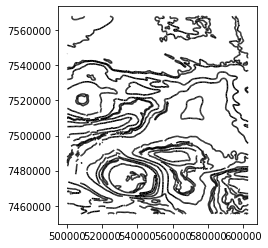

In [4]:
m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,bbox,dcode,ddcode,gcode,ccode,scheme,contact_decimate)


In [5]:
def bboxes_intersect(bbox1,bbox2):
        if(bbox1[0]<=bbox2[2] and bbox1[0]>=bbox2[0] and bbox1[1]<=bbox2[3] and bbox1[1]>=bbox2[1]):
            return(True)
        elif(bbox1[0]<=bbox2[2] and bbox1[0]>=bbox2[0] and bbox1[3]<=bbox2[3] and bbox1[3]>=bbox2[1]):
            return(True)
        elif(bbox1[2]<=bbox2[2] and bbox1[2]>=bbox2[0] and bbox1[1]<=bbox2[3] and bbox1[1]>=bbox2[1]):
            return(True)
        elif(bbox1[2]<=bbox2[2] and bbox1[2]>=bbox2[0] and bbox1[3]<=bbox2[3] and bbox1[3]>=bbox2[1]):
            return(True)
        elif(bbox2[0]<=bbox1[2] and bbox2[0]>=bbox1[0] and bbox2[3]<=bbox1[3] and bbox2[3]>=bbox1[1]):
            return(True)
        else:
            return(False)
        


In [6]:
contact_points_file=tmp_path+'raw_contacts.csv'
interpolated_combo_file=tmp_path+'combo_full.csv'
contact_lines = gpd.read_file(tmp_path+'/basal_contacts2.shp') #load orientation data as geopandas dataframe 
all_sorts=pd.read_csv(tmp_path+mname+'_all_sorts.csv')


def pt_dist(x1,y1,x2,y2):
    dist=sqrt(pow(x1-x2,2)+pow(y1-y2,2))
    return(dist)


def bboxes_intersect(bbox1,bbox2):
        if(bbox1[0]<=bbox2[2] and bbox1[0]>=bbox2[0] and bbox1[1]<=bbox2[3] and bbox1[1]<=bbox2[1]):
            return(True)
        elif(bbox1[0]<=bbox2[2] and bbox1[0]>=bbox2[0] and bbox1[3]<=bbox2[3] and bbox1[3]<=bbox2[1]):
            return(True)
        elif(bbox1[2]<=bbox2[2] and bbox1[2]>=bbox2[0] and bbox1[1]<=bbox2[3] and bbox1[1]<=bbox2[1]):
            return(True)
        elif(bbox1[2]<=bbox2[2] and bbox1[2]>=bbox2[0] and bbox1[3]<=bbox2[3] and bbox1[3]<=bbox2[1]):
            return(True)
        elif(bbox2[0]<=bbox1[2] and bbox2[0]>=bbox1[0] and bbox2[3]<=bbox1[3] and bbox2[3]<=bbox1[1]):
            return(True)
        else:
            return(False)
        
def calc_thickness(contact_points_file,interpolated_combo_file,contact_lines,output_path,buffer,max_thickness_allowed):
    contacts=pd.read_csv(contact_points_file)
    orientations=pd.read_csv(interpolated_combo_file)
    olength=len(orientations)
    clength=len(contacts)
    cx=contacts['X'].to_numpy()

    cy=contacts['Y'].to_numpy()
    cl=contacts['lsx'].to_numpy(dtype=float)
    cm=contacts['lsy'].to_numpy(dtype=float)
    ctextcode=contacts['formation'].to_numpy()
    ox=orientations['X'].to_numpy()
    oy=orientations['Y'].to_numpy()
    dip=orientations['dip'].to_numpy().reshape(olength,1)
    azimuth=orientations['azimuth'].to_numpy().reshape(olength,1)

    l = np.zeros(len(ox))
    m = np.zeros(len(ox))
    n = np.zeros(len(ox))    
    file=open(output_path+'formation_thicknesses.csv','w')
    file.write('X,Y,formation,thickness,cl,cm,meanl,meanm,meann,p1x,p1y,p2x,p2y,dip\n')
    dist=m2l_interpolation.distance_matrix(ox,oy,cx,cy)
    
    #np.savetxt(tmp_path+'dist.csv',dist,delimiter=',')
    #display("ppp",cx.shape,cy.shape,ox.shape,oy.shape,dip.shape,azimuth.shape,dist.shape)
    n_est=0
    for k in range(0,clength): #loop through all contact segments
        a_dist=dist[:,k:k+1]
        is_close=a_dist<buffer 
        #display("ic",a_dist.shape,is_close.shape,dip.shape)
        close_dip=dip[is_close]
        #print("cd",close_dip.shape)
        #print(close_dip)
        close_azimuth=azimuth[is_close]
        n_good=0
        for j in range(0,len(close_dip)): #find averaged dips within buffer
            l[n_good],m[n_good],n[n_good]=m2l_utils.ddd2dircos(float(close_dip[j]),float(close_azimuth[j])+90.0)
            #print(k,len(close_dip),n_good,l[n_good],m[n_good],n[n_good])
            n_good=n_good+1
        if(n_good>0): #if we found any candidates
            lm=np.mean(l[:n_good]) #average direction cosine of points within buffer range
            mm=np.mean(m[:n_good])
            nm=np.mean(n[:n_good])
            dip_mean,dipdirection_mean=m2l_utils.dircos2ddd(lm,mm,nm)
            #print(k,type(cm[k]),type(buffer))

            dx1=-cm[k]*buffer
            dy1=cl[k]*buffer
            dx2=-dx1
            dy2=-dy1
            p1=Point((dx1+cx[k],dy1+cy[k]))
            p2=Point((dx2+cx[k],dy2+cy[k]))
            ddline=LineString((p1,p2))
            orig = Point((cx[k],cy[k]))
            
            crossings=np.zeros((1000,5))
            
            g=0
            for apair in all_sorts.iterrows(): #loop through all basal contacts

                if(ctextcode[k]==apair[1]['code']):
                    #if(all_sorts.iloc[g]['group']==all_sorts.iloc[g-1]['group']):
                    is_contacta=contact_lines['CODE'] == all_sorts.iloc[g-1]['code'] # subset contacts to just those with a code
                    acontacts = contact_lines[is_contacta]
                    i=0 
                    for acontact in acontacts.iterrows():   #loop through distinct linestrings for upper contact
                        #if(bboxes_intersect(ddline.bounds,acontact[1].geometry.bounds)):
                        if(ddline.intersects(acontact[1].geometry)): 
                            isects=ddline.intersection(acontact[1].geometry)
                            if(isects.geom_type=="MultiPoint"):
                                for pt in isects: 
                                    if(pt.distance(orig)<buffer*2):
                                        #print(i,",", pt.x, ",",pt.y,",",apair[1]['code'],",",apair[1]['group'])
                                        crossings[i,0]=i
                                        crossings[i,1]=int(apair[1]['index'])
                                        crossings[i,2]=0
                                        crossings[i,3]=pt.x
                                        crossings[i,4]=pt.y
                                        i=i+1
                            else:
                                if(isects.distance(orig)<buffer*2):
                                    #print(i,",", isects.x,",", isects.y,",",apair[1]['code'],",",apair[1]['group'])
                                    crossings[i,0]=i
                                    crossings[i,1]=int(apair[1]['index'])
                                    crossings[i,2]=0
                                    crossings[i,3]=isects.x
                                    crossings[i,4]=isects.y
                                    i=i+1
                    if(i>0): #if we found any intersections with base of next higher unit
                        min_dist=1e8
                        min_pt=0
                        for f in range(0,i): #find closest hit
                            this_dist=pt_dist(crossings[f,3],crossings[f,4],cx[k],cy[k])
                            if(this_dist<min_dist):
                                min_dist=this_dist
                                min_pt=f
                        if(min_dist<max_thickness_allowed): #if not too far, add to output
                            true_thick=sin(radians(dip_mean))*min_dist
                            ostr=str(cx[k])+','+str(cy[k])+','+ctextcode[k]+','+str(int(true_thick))+\
                                ','+str(cl[k])+','+str(cm[k])+','+str(lm)+','+str(mm)+','+str(nm)+','+\
                                str(p1.x)+','+str(p1.y)+','+str(p2.x)+','+str(p2.y)+','+str(dip_mean)+'\n'
                            file.write(ostr)
                            n_est=n_est+1
                                
                g=g+1
    print(n_est,'thickness estimates saved as',output_path+'formation_thicknesses.csv')

In [7]:
calc_thickness(contact_points_file,interpolated_combo_file,contact_lines,output_path,buffer,max_thickness_allowed)

1047 thickness estimates saved as ../test_data3/output/formation_thicknesses.csv
